In [109]:
import argparse
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt

In [95]:
input_path = "./data/raw/2023_set_n1/2023_01_04-00_16_30.csv"
df = pd.read_csv(input_path)
freq = [x for x in df.columns if "CL" in x]
data = df[freq].to_numpy()
time = 0.02 * np.arange(data.shape[0])


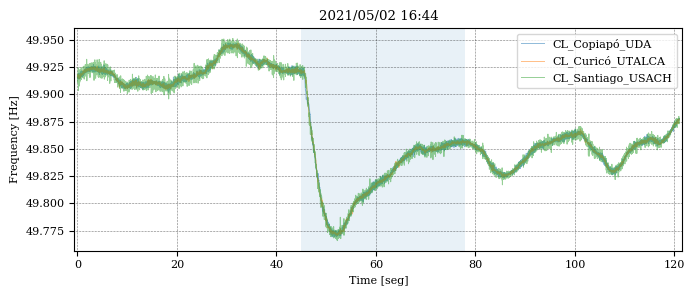

In [98]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)
plt.rcParams['axes.xmargin'] = .005

fig = plt.figure(figsize=(7,3))

t0 = 45
tm = 78
plt.axvspan(t0, tm, alpha=.1)

plt.grid(color='k', linestyle='dotted', linewidth=.4)

plt.plot(time, data, alpha=.5, linewidth=.7)
plt.title("2021/05/02 16:44")
plt.xlabel("Time [seg]")
plt.ylabel("Frequency [Hz]")

plt.legend(freq)

#plt.text( 60.5, 49.815, 'Identification\nInterval', alpha=.3)

fig.tight_layout()

plt.savefig('./img/DataExample.pdf')

In [108]:
instance = "2023_01_04-00_16_30"
et = 20
model = "B2"
for i in range(6):
    et = et + 5
    output_dir = f"test/test_interval_exp_paper/{et}/"
    parameters = "30,0.56261,0.74232"
    if not os.path.isdir(output_dir):
                os.makedirs(output_dir)

    os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}")
    os.system(f"python src/de_run.py -i {output_dir}{instance}_sampled.csv -o {output_dir} -m {model} -p {parameters}")

------------------------------------------------------------------------------------
   input: 2023_01_04-00_16_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0023104935138992637
       x: [ 6.663e+02  9.589e+02  3.614e+01  5.883e-01  5.326e+00]
     nit: 65
    nfev: 9900
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
   input: 2023_01_04-00_16_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0012830615779665512
       x: [ 1.864e+01  2.932e+01  8.538e+00  7.013e-01  

In [127]:
import pickle
import models as mdl
from scipy import signal

Text(0, 0.5, 'Δf [Hz]')

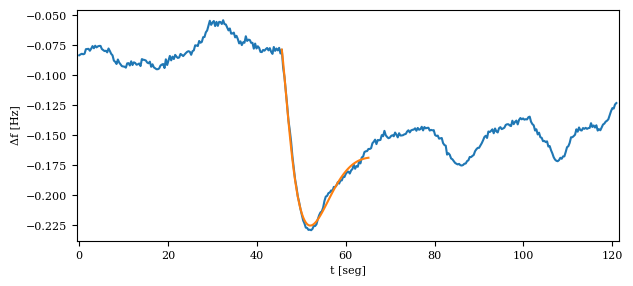

In [133]:
instance = "2023_01_04-00_16_30"
et = 20
output_dir = f"test/test_interval_exp_paper/{et}/"

file = open(f"{output_dir}{instance}_sampled_result.p", 'rb')
result = pickle.load(file)
file.close()
x = result.x
df = pd.read_csv(f"{output_dir}{instance}_sampled.csv")  
Ts = df["time"][1]
P0 = -df["power"][0] / 1000
event_freq = df["delta_freq"][df["event"]==1].to_numpy()

if model == "b":
    sys = mdl.modelo_b(x, Ts)
elif model == "c":
    sys = mdl.modelo_c(x, Ts)
elif model == "cc":
    sys = mdl.modelo_cc(x, Ts)
    ########################################
elif model == "A1":
    sys = mdl.modelo_A1(x, Ts)
elif model == "A2":
    sys = mdl.modelo_A2(x, Ts)
elif model == "B1":
    sys = mdl.modelo_B1(x, Ts)
elif model == "B2":
    sys = mdl.modelo_B2(x, Ts)
    
sim_power = P0 * np.repeat(1, event_freq.shape)
sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
sim_freq = sim[1].ravel()
    
real_time = df["time"].to_numpy()
real_freq = df["delta_freq"].to_numpy()
    
event_time = df["time"][df["event"]==1].to_numpy()

sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)

fig = plt.figure(figsize=(7,3))
    
plt.plot(real_time,real_freq)
plt.plot(sim_time,sim_freq)
plt.xlabel("t [seg]")
plt.ylabel("Δf [Hz]")

In [124]:
event_freq

array([-0.0784767, -0.0934657, -0.10134  , -0.112742 , -0.124601 ,
       -0.137626 , -0.145753 , -0.155387 , -0.16781  , -0.176959 ,
       -0.186847 , -0.193058 , -0.200789 , -0.205604 , -0.211372 ,
       -0.216048 , -0.22084  , -0.223364 , -0.226817 , -0.227119 ,
       -0.228729 , -0.228548 , -0.229012 , -0.227928 , -0.225405 ,
       -0.225487 , -0.224079 , -0.219935 , -0.216542 , -0.214203 ,
       -0.213307 , -0.210216 , -0.204623 , -0.200939 , -0.200394 ,
       -0.198061 , -0.197589 , -0.195834 , -0.196455 , -0.192952 ,
       -0.192985 , -0.191759 , -0.188982 , -0.190185 , -0.187617 ,
       -0.187494 , -0.184606 , -0.184656 , -0.182068 , -0.180654 ,
       -0.180144 , -0.181754 , -0.179202 , -0.177989 , -0.174248 ,
       -0.177781 , -0.1755   , -0.17617  , -0.171802 , -0.173316 ,
       -0.168331 , -0.167666 , -0.163872 , -0.163225 , -0.163042 ,
       -0.161285 ])